# Part 0: Load in libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


## 0.1 - Create definition for intersection

In [2]:
def longest_str_intersection(a: str, b: str):

    # identify all possible character sequences from str a
    seqs = []
    for pos1 in range(len(a)):
        for pos2 in range(len(a)):
            seqs.append(a[pos1:pos2+1])
        
    # remove empty sequences
    seqs = [seq for seq in seqs if seq != '']

    # find segments in str b
    max_len_match = 0
    max_match_sequence = ''
    for seq in seqs:
        if seq in b:
            if len(seq) > max_len_match:
                max_len_match = len(seq)
                max_match_sequence = seq

    return max_match_sequence

In [ ]:
# Things to do: 
# 1. Will need full sequences from both proteins and then be able to split by each protein
# 2. Will need to know which protein has the DNA binding domain
# 3. Will need to extract IDRs that have been added to the DNA binding domain protein
# 4. Will need to extract IDRs that have been removed from the DNA binding domain protein
# 5. For each set of IDRs will need to calculate #M, #Q, #Y, and pos-neg patterning

# The question here is does fusions of DNA binding proteins add IDR grammars of the nucleus
# Especially cause we think these grammars might be important for localization / partner recruitment

# Part 1: Load in relevant data

## 1.1 - Load in fusion sequences from Tripathi et al. and filtered to only have those that contain a DNA binding domain

In [20]:
fusiondf=pd.read_excel('data/fusions/Tripathi_etal_NatComm_2023_Fusions_w_DNA_binding_domains.xlsx')

print(fusiondf)

tmpdf=fusiondf[fusiondf['Tail Length']<50]
print(tmpdf[['FO_Name','Tail Length']])
shorttails=tmpdf['FO_Name'].tolist()

foname=fusiondf['FO_Name'].tolist()
headst=fusiondf['Start Head'].tolist()
headen=fusiondf['End Head'].tolist()
tailst=fusiondf['Start Tail'].tolist()
tailen=fusiondf['End Tail'].tolist()

     Unnamed: 0        FO_Name  Patient_Count Puncta_Prediction  \
0           880     ETV6_RUNX1            185               YES   
1          2741      TCF3_PBX1             78               YES   
2          2329  RUNX1_RUNX1T1             50               YES   
3           385  C11orf95_RELA             35               YES   
4          1534     MEF2D_BCL9             31               YES   
..          ...            ...            ...               ...   
399        1052   GMDS_MRPS18B              1               YES   
400        1029   GBE1_ZNF385D              1               YES   
401        1102   GSK3A_ZNF564              1                NO   
402        1115   GTF3C4_LMX1B              1                NO   
403        1078  GPATCH8_ZMYM4              1                NO   

    Predicted_Group_Assignment   cor     p Predicted_Function  \
0                      Group 3  0.98  0.00           Gene_reg   
1                      Group 1  0.96  0.00           Gene_reg   


## 1.2 - Load in DNA binding information

In [4]:
DNAbinddf=pd.read_table('data/fusions/BLAST_CDD_PFAM_DNA/Tripathi_Fusion_Sequences_BLAST_CDD_PFAM_DNA.txt',header=None)

print(DNAbinddf)

uniDNAbindfusions=[]
for i in range(0,len(DNAbinddf[0].tolist())):
    if DNAbinddf[0].tolist()[i] not in uniDNAbindfusions:
        uniDNAbindfusions.append(DNAbinddf[0].tolist()[i])
        
print(len(uniDNAbindfusions))

DNAbindFO=DNAbinddf[0].tolist()
DNAbindst=DNAbinddf[6].tolist()
DNAbinden=DNAbinddf[7].tolist()

                   0           1       2    3   4   5    6    7   8    9   \
0           PAX5_PAX5  CDD:238076  81.102  127  24   0   16  142   1  127   
1           PAX5_PAX5  CDD:238076  81.102  127  24   0  202  328   1  127   
2           PAX5_PAX5  CDD:366005  89.600  125  13   0   16  140   1  125   
3           PAX5_PAX5  CDD:366005  89.600  125  13   0  202  326   1  125   
4           PAX5_PAX5  CDD:238042  25.490   51  37   1   30   79   1   51   
...               ...         ...     ...  ...  ..  ..  ...  ...  ..  ...   
4115     GSK3A_ZNF564  CDD:395048  56.522   23  10   0  493  515   1   23   
4116  GTF2A1_KIAA0391  CDD:199899  70.588   34  10   0   10   43   1   34   
4117     GTF3C4_LMX1B  CDD:425441  46.296   54  29   0  885  938   1   54   
4118     GTF3C4_LMX1B  CDD:238039  45.614   57  31   0  883  939   1   57   
4119    GPATCH8_ZMYM4  CDD:432381  42.857   28  14   1  136  163   2   27   

                10     11  
0     2.150000e-81  245.0  
1     2.150000e-81 

## 1.3 - Load in Human IDRome info

In [5]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
fullzvec=np.load('../general_data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(fullzvec.shape)

humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx', engine='openpyxl')

print(humandf.isnull().any())
humandf = humandf.fillna('')

for f in range(0,len(myfeat)):
    humandf[myfeat[f]]=fullzvec[:,f]

## Get IDRs of sufficient length
minidrlength=50
minidrlinkerlength=70
humandf=humandf[humandf['IDR Length']>=minidrlength]
humandf=humandf[ (humandf['IDR Length']>=minidrlinkerlength) | (humandf['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]


fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

fullgenes=[]
for i in range(0,len(fullgeneswnums)):
    tmp=fullgeneswnums[i].split(' ')
    fullgenes.append(tmp[0])
    
#print(fullgenes[0:10])

print(humandf)

90
(24508, 90)
Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24498       24498  Q6ZSZ5         Q6Z

# Part 2: Determine which parent protein has a DNA binding domain

## 2.1 - Check for DNA binding domain

In [6]:
headDNAbinding=[]
tailDNAbinding=[]

for s in range(0,len(foname)):
    pos=[i for i, x in enumerate(DNAbindFO) if x==foname[s]]
    currheadidx=np.arange(headst[s],headen[s])
    currtailidx=np.arange(tailst[s],tailen[s])
    #print(currheadidx)
    #print(currtailidx)
    #print(pos)
    currheadbind='No'
    currtailbind='No'
    for p in pos:
        tmpbindst=DNAbindst[p]
        tmpbinden=DNAbinden[p]
        #print(tmpbindst)
        #print(tmpbinden)
        if tmpbindst in currheadidx:
            if tmpbinden in currheadidx:
                currheadbind='Yes'
        if tmpbindst in currtailidx:
            if tmpbinden in currtailidx:
                currtailbind='Yes'

    headDNAbinding.append(currheadbind)
    tailDNAbinding.append(currtailbind)
    #print(foname[s])
    #print(currheadbind)
    #print(currtailbind)
    #print(tmpbinden in currtailidx)
    #hi

## 2.2 - Add to dataframe and remove bad sequences

In [19]:
fusionwbinddf=fusiondf
fusionwbinddf['Head DNA Binding']=headDNAbinding
fusionwbinddf['Tail DNA Binding']=tailDNAbinding

#print(fusionwbinddf)

tmpdf=fusionwbinddf[fusionwbinddf['FO_Name'].str.contains('MEF2D')]
print(tmpdf[['FO_Name','Head Sequence','Head DNA Binding','Tail DNA Binding']])

fusionwbinddf=fusionwbinddf.loc[fusionwbinddf['Head DNA Binding'] != fusionwbinddf['Tail DNA Binding']]

print(fusionwbinddf)

## Have to remove some sequences because don't match original sequence - may have insertions
## Or says loss of IDR but mostly still there besides some insertion or slight changes to sequence
fusionwbinddf=fusionwbinddf[~fusionwbinddf['FO_Name'].str.contains('ZNF384')]
fusionwbinddf=fusionwbinddf[~fusionwbinddf['FO_Name'].str.contains('NCOR1_NFIA')]
fusionwbinddf=fusionwbinddf[~fusionwbinddf['FO_Name'].str.contains('ZMYND8_GTPBP1')]
fusionwbinddf=fusionwbinddf[~fusionwbinddf['FO_Name'].str.contains('CHD7_TCF7L2')]
fonamefinal=fusionwbinddf['FO_Name'].tolist()

print(fusionwbinddf)
#print(fonamefinal)

#with pd.ExcelWriter('../Supplementary_Tables/Table_S7.xlsx', engine='openpyxl',mode='a') as writer:
#    fusionwbinddf.to_excel(writer,sheet_name='Tripathi_fusion_data_w_DNA_bind')

            FO_Name                                      Head Sequence  \
4        MEF2D_BCL9  MGRKKIQIQRITDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...   
22   MEF2D_HNRNPUL1  MGRKKIQIQRITDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...   
53       MEF2D_SS18  MGRKKIQIQRITDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...   
56     MEF2D_DAZAP1  MGRKKIQIQRITDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...   
338    MEF2D_ZDHHC5  MGRKKIQIQRITDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...   
349    MEF2D_HNRNPM  MGRKKIQIQRITDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...   
350     MEF2D_FOXJ2  MGRKKIQIQRITDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...   
351     MEF2D_CSF1R  MGRKKIQIQRITDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...   

    Head DNA Binding Tail DNA Binding  
4                Yes              Yes  
22               Yes               No  
53               Yes               No  
56               Yes              Yes  
338              Yes               No  
349              Yes               No  
350              Yes               No  
351          

/project/engineering/anaconda3/lib/python3.7/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [8]:
tmpdf=fusionwbinddf[fusionwbinddf['FO_Name'].str.contains('FOXO1')]
print(tmpdf[['FO_Name','Head Sequence','Head DNA Binding','Tail DNA Binding']])

Empty DataFrame
Columns: [FO_Name, Head Sequence, Head DNA Binding, Tail DNA Binding]
Index: []


# Part 3: Analyze IDRs gained vs lost combine IDRs

## 3.1 - Get data for gained vs lost IDRs from the perspective of the protein housing the DNA binding domain

In [10]:
gainedIDRnumY=[]
gainedIDRnumQ=[]
gainedIDRnumM=[]
gainedIDRnumP=[]
gainedIDRpolpol=[]
gainedIDRposneg=[]
gainedIDRnegneg=[]
lostIDRnumY=[]
lostIDRnumQ=[]
lostIDRnumM=[]
lostIDRnumP=[]
lostIDRpolpol=[]
lostIDRposneg=[]
lostIDRnegneg=[]
goodfoname=[]
countIDRlostgained=0
for s in range(0,len(fonamefinal)):
    currfoname=fonamefinal[s]
    
    # Determine which has the DNA binding domain
    whichDNAbind=''
    if fusionwbinddf['Head DNA Binding'].tolist()[s]=='Yes':
        whichDNAbind='Head'
    elif fusionwbinddf['Tail DNA Binding'].tolist()[s]=='Yes':
        whichDNAbind='Tail'        
    #print(whichDNAbind)
    
    currheadgene=currfoname.split('_')[0]
    currtailgene=currfoname.split('_')[1]

    # Get Head sequence information
    currfullheadseq=fusionwbinddf['Full Head Gene Seq'].tolist()[s]
    currfusionheadseq=fusionwbinddf['Head Sequence'].tolist()[s]
    
    # Get Tail sequence information
    currfulltailseq=fusionwbinddf['Full Tail Gene Seq'].tolist()[s]
    currfusiontailseq=fusionwbinddf['Tail Sequence'].tolist()[s]
    
    # Find all IDRs associated head gene
    poshead=[i for i, x in enumerate(fullgenes) if x==currheadgene]
    
    # Find all IDRs associated tail gene
    postail=[i for i, x in enumerate(fullgenes) if x==currtailgene]

    curridrseqf=''
    curridrseqo=''
    tmpYf=[]
    tmpPf=[]
    tmpQf=[]
    tmpMf=[]
    tmppolf=[]
    tmppnf=[]
    tmpnnf=[]
    tmpYo=[]
    tmpPo=[]
    tmpQo=[]
    tmpMo=[]
    tmppolo=[]
    tmppno=[]
    tmpnno=[]
    tmpidrlost=[]
    tmpidrgain=[]
    if whichDNAbind=='Tail':
        for p in poshead:
            curridrseq=fullseqs[p]

                
            if curridrseq in currfusionheadseq:
                curridrseqf=curridrseq
                SeqOb=SequenceParameters(curridrseqf)
                aafrac=SeqOb.get_amino_acid_fractions()
                tmpYf.append(humandf['Frac Y'].tolist()[p])
                tmpPf.append(humandf['Frac P'].tolist()[p])
                tmpQf.append(humandf['Q Patch'].tolist()[p])
                tmpMf.append(humandf['Frac M'].tolist()[p])
                tmppolf.append(humandf['pol-pol'].tolist()[p])
                tmppnf.append(humandf['pos-neg'].tolist()[p])
                tmpnnf.append(humandf['neg-neg'].tolist()[p])
                tmpidrgain.append(curridrseq)
         
        for p in postail:
            curridrseq=fullseqs[p]

            tmpovla=longest_str_intersection(curridrseq, currfusiontailseq)
            if (len(tmpovla)/len(curridrseq)<0.25):
                #print(currfoname)
                #print(curridrseq)
                #print(currfusiontailseq)
                #print(tmpovla)
                curridrseqo=curridrseq
                SeqOb=SequenceParameters(curridrseqo)
                aafrac=SeqOb.get_amino_acid_fractions()
                tmpYo.append(humandf['Frac Y'].tolist()[p])
                tmpPo.append(humandf['Frac P'].tolist()[p])
                tmpQo.append(humandf['Q Patch'].tolist()[p])
                tmpMo.append(humandf['Frac M'].tolist()[p])
                tmppolo.append(humandf['pol-pol'].tolist()[p])
                tmppno.append(humandf['pos-neg'].tolist()[p])
                tmpnno.append(humandf['neg-neg'].tolist()[p])
                tmpidrlost.append(curridrseq)
        
    elif whichDNAbind=='Head':
        for p in poshead:
            curridrseq=fullseqs[p]
        
            tmpovla=longest_str_intersection(curridrseq, currfusionheadseq)
            if (len(tmpovla)/len(curridrseq)<0.25):
                curridrseqo=curridrseq
                SeqOb=SequenceParameters(curridrseqo)
                aafrac=SeqOb.get_amino_acid_fractions()
                tmpYo.append(humandf['Frac Y'].tolist()[p])
                tmpPo.append(humandf['Frac P'].tolist()[p])
                tmpQo.append(humandf['Q Patch'].tolist()[p])
                tmpMo.append(humandf['Frac M'].tolist()[p])
                tmppolo.append(humandf['pol-pol'].tolist()[p])
                tmppno.append(humandf['pos-neg'].tolist()[p])
                tmpnno.append(humandf['neg-neg'].tolist()[p])
                tmpidrlost.append(curridrseq)
                
        for p in postail:
            curridrseq=fullseqs[p]
            

            if curridrseq in currfusiontailseq:
                curridrseqf=curridrseq
                SeqOb=SequenceParameters(curridrseqf)
                aafrac=SeqOb.get_amino_acid_fractions()
                tmpYf.append(humandf['Frac Y'].tolist()[p])
                tmpPf.append(humandf['Frac P'].tolist()[p])
                tmpQf.append(humandf['Q Patch'].tolist()[p])
                tmpMf.append(humandf['Frac M'].tolist()[p])
                tmppolf.append(humandf['pol-pol'].tolist()[p])
                tmppnf.append(humandf['pos-neg'].tolist()[p])
                tmpnnf.append(humandf['neg-neg'].tolist()[p]) 
                tmpidrgain.append(curridrseq)
                
                
    if curridrseqf and curridrseqo:
        countIDRlostgained+=1
        #print(str(countIDRlostgained)+'. '+currfoname+' - DNA binding in '+whichDNAbind)
        #print(fusionwbinddf['AASeq'].tolist()[s])
        #print(' ')
        goodfoname.append(currfoname)
        gainedIDRnumY.append(max(tmpYf))
        gainedIDRnumP.append(max(tmpPf))
        gainedIDRnumQ.append(max(tmpQf))
        gainedIDRnumM.append(max(tmpMf))
        gainedIDRpolpol.append(max(tmppolf))
        gainedIDRposneg.append(max(tmppnf))
        gainedIDRnegneg.append(max(tmpnnf))
        lostIDRnumY.append(max(tmpYo))
        lostIDRnumP.append(max(tmpPo))
        lostIDRnumQ.append(max(tmpQo))
        lostIDRnumM.append(max(tmpMo))
        lostIDRpolpol.append(max(tmppolo))
        lostIDRposneg.append(max(tmppno))
        lostIDRnegneg.append(max(tmpnno))
        print(str(countIDRlostgained)+'. '+currfoname+' - DNA binding in '+whichDNAbind)
        print(fusionwbinddf['AASeq'].tolist()[s])
        for i in range(0,len(tmpidrlost)):
            print('>IDR_Lost_'+str(i+1))
            print(tmpidrlost[i])
        for i in range(0,len(tmpidrgain)):
            print('>IDR_Gained_'+str(i+1))
            print(tmpidrgain[i])
        print(' ')
        
        
        

1. SAFB2_SAFB - DNA binding in Tail
MAETLPGSGDSGPGTASLGPGVAETGTRRLSELRVIDLRAELKKRNLDTGGNKSVLMERLKKAVKEEGQDPDEIGIELEATSKKSAKRCVKGLKMEEEGTEDNGLEDDSRDGQEDMEASLENLQNMGMMDMSVLDETEVANSSAPDFGEDGTDGLLDSFCDSKEYVAAQLRQLPAQPPEHAVDGEGFKNTLETSSLNFKVTPDIEESLLEPENEKILDILGETCKSEPVKEESSELEQPFAQDTSSVGPDRKLAEEEDLFDSAHPEEGDLDLASESTAHAQSSKADSLLAVVKREPAEQPGDGERTDCEPVGLEPAVEQSSAASELAEASSEELAEAPTEAPSPEARDSKEDGRKFDFDACNEVPPAPKESSTSEGADQKMSSFKEEKDIKPIIKDEKGRVGSGSGRNLWVSGLSSTTRATDLKNLFSKYGKVVGAKVVTNARSPGARCYGFVTMSTAEEATKCINHLHKTELHGKMISVEKAKNEPVGKKTSDKRDSDGKKEKSSNSDRSTNLKRDDKCDRKDDAKKGDDGSGEKSKDQDDQKPGPSERSRATKSGSRGTERTVVMDKSKGVPVISVKTSGSKERASKSQDRKSASREKRSVVSFDKVKEPRKSRDSESHSRVRERSEREQRMQAQWEREERERLEIARERLAFQRQRLERERMERERLERERMHVEHERRREQERIHREREELRRQQELRYEQERRPAVRRPYDLDRRDDAYWPEAKRAALDERYHSDFNRQDRFHDFDHRDRGRYPDHSVDRREGSRSMMGEREGQHYPERHGGPERHGRDSRDGWGGYGSDKRMSEGRGLPPPPRGRRDWGDHGRREDDRSWQGTADGGMMDRDHKRWQGGERSMSGHSGPGHMMNRGGMSGRGSFAPGGASRGHPIPHGGMQGGFGGQSRGSRPSDARFTRRY
>IDR_Lost_1
ELRKRNVDSSGNKSVLMERLKKAIEDEGGNPDE

6. EP300_BCOR - DNA binding in Tail
MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDELINSTELGLTNGGDINQLQTSLGMVQDAASKHKQLSELLRSGSSPNLNMGVGGPGQVMASQAQQSSPGLGLINSMVKSPMTQAGLTSPNMGMGTSGPNQGPTQSTGMMNSPVNQPAMGMNTGMNAGMNPGMLAAGNGQGIMPNQVMNGSIGAGRGRQNMQYPNPGMGSAGNLLTEPLQQGSPQMGGQTGLRGPQPLKMGMMNNPNPYGSPYTQNPGQQIGASGLGLQIQTKTVLSNNLSPFAMDKKAVPGGGMPNMGQQPAPQVQQPGLVTPVAQGMGSGAHTADPEKRKLIQQQLVLLLHAHKCQRREQANGEVRQCNLPHCRTMKNVLNHMTHCQSGKSCQVAHCASSRQIISHWKNCTRHDCPVCLPLKNAGDKRNQQPILTGAPVGLGNPSSLGVGQQSAPNLSTVSQIDPSSIERAYAALGLPYQVNQMPTQPQVQAKNQQNQQPGQSPQGMRPMSNMSASPMGVNGGVGVQTPSLLSDSMLHSAINSQNPMMSENASVPSLGPMPTAAQPSTTGIRKQWHEDITQDLRNHLVHKLVQAIFPTPDPAALKDRRMENLVAYARKVEGDMYESANNRAEYYHLLAEKIYKIQKELEEKRRTRLQKQNMLPNAAGMVPVSMNPGPNMGQPQPGMTSNGPLPDPSMIRGSVPNQMMPRITPQSGLNQFGQMSMAQPPIVPRQTPPLQHHGQLAQPGALNPPMGYGPRMQQPSNQGQFLPQTQFPSQGMNVTNIPLAPSSGQAPVSQAQMSSSSCPVNSPIMPPGSQGSHIHCPQLPQPALHQNSPSPVPSRTPTPHHTPPSIGAQQPPATTIPAPVPTPPAMPPGPQSQALHPPPRQTPTPPTTQLPQQVQPSLPAAPSADQPQQQPRSQQSTAASVPTPTAPLLPPQPATPLSQPAVSIEGQVSNPPSTSSTEVNS

12. U2AF2_RERE - DNA binding in Tail
MSDFDEFERQLNENKQERDKENRHRKRSHSRSRSRDRKRRSRSRDRRNRDQRSASRDRRRRSKPLTRGAKEEHGGLIRSPRHEKKKKVRKYWDVPPPGFEHITPMQYKAMQAAGQIPATALLPTMTPDGLAVTPTPVPVVGSQMTRQARRLYVGNIPFGITEGELITFYYYWKKTPEAASSRAHRRHRRQAVFRRIKTRTASTPVNTPSRPPSSEFLDLSSASEDDFDSEDSEQELKGYACRHCFTTTSKDWHHGGRENILLCTDCRIHFKKYGELPPIEKPVDPPPFMFKPVKEEDDGLSGKHSMRTRRSRGSMSTLRSGRKKQPASPDGRTSPINEDIRSSGRNSPSAASTSSNDSKAETVKKSAKKVKEEASSPLKSNKRQREKVASDTEEADRTSSKKTKTQEISRPNSPSEGEGESSDSRSVNDEGSSDPKDIDQDNRSTSPSIPSPQDNESDSDSSAQQQMLQAQPPALQAPTGVTPAPSSAPPGTPQLPTPGPTPSATAVPPQGSPTASQAPNQPQAPTAPVPHTHIQQAPALHPQRPPSPHPPPHPSPHPPLQPLTGSAGQPSAPSHAQPPLHGQGPPGPHSLQAGPLLQHPGPPQPFGLPPQASQGQAPLGTSPAAAYPHTSLQLPASQSALQSQQPPREQPLPPAPLAMPHIKPPPTTPIPQLPAPQAHKHPPHLSGPSPFSMNANLPPPPALKPLSSLSTHHPPSAHPPPLQLMPQSQPLPSSPAQPPGLTQSQNLPPPPASHPPTGLHQVAPQPPFAQHPFVPGGPPPITPPTCPSTSTPPAGPGTSAQPPCSGAAASGGSIAGGSSCPLPTVQIKEEALDDAEEPESPPPPPRSPSPEPTVVDTPSHASQSARFYKHLDRGYNSCARTDLYFMPLAGSKLAKKREEAIEKAKREAEQKAREEREREKEKEKEREREREREREAERAAKASSSAHEGRLSDPQLSGPGHMR

19. SCML2_MAP7D2 - DNA binding in Head
MGQTVNEDSMDVKKENQEKTPQSSTSSVQRDDFHWEEYLKETGSISAPSECFRQSQIPPVNDFKVGMKLEARDPRNATSVCIATVIGITGARLRLRLDGSDNRNDFWRLVDSPDIQPVGTCEKEGDLLQPPLGYQMNTSSWPMFLLKTLNGSEMASATLFKKEPPKPPLNNFKVGMKLEAIDKKNPYLICPATIGDVKGDEVHITFDGWSGAFDYWCKYDSRDIFPAGWCRLTGDVLQPPGTSGMEGFLKSDERQRLAKERREEREKCLAAREQQILEKQKRARLQYEKQMEERWRKLEEQRQREDQKRAAVEEKRKQKLREEEERLEAMMRRSLERTQQLELKKKYSWGAPLAIGPGGHDACDKLSTSTMSLPKPTEPPMNKRLSSSTVAISYSPDRAHHMHLSPMEAILVSRLLTPTQSSLARSRASVMLSGQANDSVFHVCPRLAPLGPLNPSYKSSPTRNIEKKKATSTSTSGAGDVGKEALSGGEASLVEKVKRGQRTATSLPVVNFGSPLRRCEFSGGIPKRPSSPVISKTATKAYPQSPKTTKPPYPGSPVKYRLPALSGQDMPKRKAEKEKSNKEREGTLAQQAAGPQGEEALEKHVVDKHASEKHAAAAGGKAENSAALGKPTAGTTDAGEAAKILAEKRRQARLQKEQEEQERLEKEEQDRLEREELKRKAEEERLRLEEEARKQEEERKRQEEEKKKQEGEEKRKAGEEAKRKAEEELLLKEKQEQEKQEKAMIEKQKEAAETKAREVAEQMRLEREQIMLQIEQERLERKKRIDEIMKRTRKSDVSPQVKKEDPKVGVQPAVCVEKKTKLVVPNKMEINGLNTCQEVNGVDHAAPETYPQDIFSNGLKPAGGLIHLDALDGKSNSLDDSTEEVQSMDVSPVSKEELISIPEFSPVSEMIPGVSLDQNGTGNARALQDLLDFTGPPTFPKRSSENLSLDDCNKNLIEGFN

25. DMWD_KDM4C - DNA binding in Tail
MAAGGAEGGSGPGAAMGDCAEIKSQFRTREGFYKLLPGDGAARRSGPASAQTPVPPQPPQPPPGPASASGPGAAGPASSPPPAGPGPGPALPAVRLSLVRLGEPDSAGAGEPPATPAGLGSGGDRVCFNLGRELYFYPGCCRRGSQRSIDLNKPIDKRIYKGTQPTCHDFNQFTAATETISLLVGFSAGQVQYLDLIKKDTSKLFNEEKSKACEKVISVGQTVITKHRNTRYYSCRVMAVTSQTFYEVMFDDGSFSRDTFPEDIVSRDCLKLGPPAEGEVVQVKWPDGKLYGAKYFGSNIAHMYQVEFEDGSQIAMKREDIYTLDEELPKRVKARFSTASDMRFEDTFYGADIIQGERKRQRVLSSRFKNEYVADPVYRTFLKSSFQKKCQKRQ
>IDR_Lost_1
KVRKASRSFQCARSTSKRPKADEEEEVSDEVDGAEVPNPDSVTDDLKVSEKSEAAVKLRNTEASSEEESSASRMQVEQNLSDHIKLSGNSCLSTSVTEDIKTEDDKAYAYRSVPSISSEADDSIPLSSGYEKPEKSDPSELSWPKSPESCSSVAESNGVLTEGEESDVESHGNGLEPGEIPAVPSGERNSFKVPSIAEGENKTSKSWRHPLSRPPARSPMTLVKQQAPSDEELPE
>IDR_Gained_1
FRTREGFYKLLPGDGAARRSGPASAQTPVPPQPPQPPPGPASASGPGAAGPASSPPPAGPGPGPALPAVRLSLVRLGEPDSAGAGEPPATPAGLGSG
 
26. ATAD2_ZFPM2 - DNA binding in Tail
MVVLRSSLELHNHSAASATGSLDLSSDFLSLEHIGRRRLRSAGAAQKKPAATTAKAGDGSSVKEVETYHRTRALRSLRKDAQNSSDSSFEKNVEITEQLANGRHFTRQLARQQADKKKEEHREDKVIPVTRSLRARNIVQSTEHLHEDNGDVEVRRSCRIRSRYSGVN

28. KAT6B_RTKN2 - DNA binding in Head
MVKLANPLYTEWILEAIQKIKKQKQRPSEERICHAVSTSHGLDKKTVSEQLELSVQDGSVLKVTNKGLASYKDPDNPGRFSSVKPGTFPKSAKGSRGSCNDLRNVDWNKLLRRAIEGLEEPNGSSLKNIEKYLRSQSDLTSTTNNPAFQQRLRLGAKRAVNNGRLLKDGPQYRVNYGSLDGKGAPQYPSAFPSSLPPVSLLPHEKDQPRADPIPICSFCLGTKESNREKKPEELLSCADCGSSGHPSCLKFCPELTTNVKALRWQCIECKTCSACRVQGRNADNMLFCDSCDRGFHMECCDPPLSRMPKGMWICQVCRPKKKGRKLLHEKAAQIKRRYAKPIGRPKNKLKQRLLSVTSDEGSMNAFTGRGSPGRGQKTKVCTTPSSGHAASGKDSSSRLAVTDPTRPGATTKITTTSTYISASTLKVNKKTKGLIDGLTKFFTPSPDGRRSRGEIIDFSKHYRPRKKVSQKQSCTSHVLATGTTQKLKPPPSSLPPPTPISGQSPSSQKSSTATSSPSPQSSSSQCSVPSLSSLTTNSQLKALFDGLSHIYTTQGQSRKKGHPSYAPPKRMRRKTELSSTAKSKAHFFGKRDIRSRFISHSSSSSWGMARGSIFKAIAHFKRTTFLKKHRMLGRLKYKVTPQMGTPSPGKGSLTDGRIKPDQDDDTEIKINIKQESADVNVIGNKDVVTEEDLDVFKQAQELSWEKIECESGVEDCGRYPSVIEFGKYEIQTWYSSPYPQEYARLPKLYLCEFCLKYMKSKNILLRHSKKCGWFHPPANEIYRRKDLSVFEVDGNMSKIYCQNLCLLAKLFLDHKTLYYDVEPFLFYVLTKNDEKGCHLVGYFSKEKLCQQKYNVSCIMIMPQHQRQGFGRFLIDFSYLLSRREGQAGSPEKPLSDLGRLSYLAYWKSVILEYLYHHHERHISIKAISRATGMCPHDIATTLQHLHMIDKRDGRFVIIRREK

## 3.2 - Plot z-scores of main nucleoplasmic and cancer grammars lost vs gained

([<matplotlib.axis.XTick at 0x14ea02657690>,
 [Text(0.5, 0, 'neg-neg'),
  Text(1.5, 0, 'pos-neg'),
  Text(2.5, 0, 'pol-pol'),
  Text(3.5, 0, 'Frac P'),
  Text(4.5, 0, 'Frac Y'),
  Text(5.5, 0, 'Frac M'),
  Text(6.5, 0, 'Q Patch')])

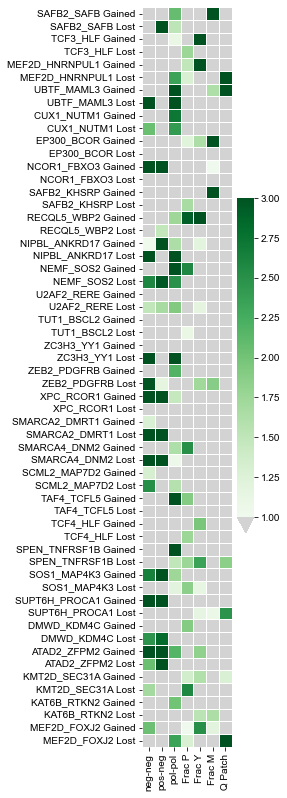

In [11]:
#mysubfeats=['Frac Q','Frac M','Frac Y','Frac P','pol-pol','pos-neg','neg-neg']
mysubfeats=['neg-neg','pos-neg','pol-pol','Frac P','Frac Y','Frac M','Q Patch']
fusionfeatsgl=[]
goodfonamegl=[]
for s in range(0,len(gainedIDRnumY)):
    fusionfeatsgl.append([gainedIDRnegneg[s],gainedIDRposneg[s],gainedIDRpolpol[s],gainedIDRnumP[s],gainedIDRnumY[s],gainedIDRnumM[s],gainedIDRnumQ[s]])
    fusionfeatsgl.append([lostIDRnegneg[s],lostIDRposneg[s],lostIDRpolpol[s],lostIDRnumP[s],lostIDRnumY[s],lostIDRnumM[s],lostIDRnumQ[s]])
    goodfonamegl.append(goodfoname[s]+' Gained')
    goodfonamegl.append(goodfoname[s]+' Lost')
    
c = sbn.color_palette('Greens', 20)
green = mpl.colors.LinearSegmentedColormap.from_list('alex_lv', c)
green.set_under(alpha=0)
green.set_under('lightgrey')
    
fig, ax = plt.subplots(figsize = (2, 15)) 

#sbn.heatmap(fusionfeatsgl,cmap='PRGn',vmin=-3,vmax=3,linewidth=0.5)
sbn.heatmap(fusionfeatsgl,cmap=green,vmin=1,vmax=3,cbar_kws={'extend': 'min'}, square=True, linewidth=.5)
plt.yticks(np.arange(0.5, len(goodfonamegl), 1), goodfonamegl,rotation=0) 
plt.xticks(np.arange(0.5, len(mysubfeats), 1), mysubfeats,rotation=90) 

#plt.savefig("fusions/figures/Tripathi_etal_DNA_binding_fusions_features_IDRs_gained_lost.pdf", transparent=True, bbox_inches = "tight") 
#plt.savefig("fusions/figures/Tripathi_etal_DNA_binding_fusions_enriched_features_IDRs_gained_lost_Q_Patch.pdf", transparent=True, bbox_inches = "tight") 


## 3.3 - Save data to excel file

In [15]:
dfvals=pd.DataFrame(fusionfeatsgl,columns=mysubfeats)
dfgenes=pd.DataFrame(goodfonamegl,columns=['Fusion'])
dftmp=pd.concat([dfgenes,dfvals],axis=1)

print(dftmp)

#with pd.ExcelWriter('../Supplementary_Tables/Table_S7.xlsx', engine='openpyxl',mode='a') as writer:
#    dftmp.to_excel(writer,sheet_name='Fig_7C')

                   Fusion    neg-neg    pos-neg   pol-pol    Frac P    Frac Y  \
0       SAFB2_SAFB Gained   0.916517   0.000000  2.071588 -0.495633 -0.608843   
1         SAFB2_SAFB Lost   0.977723   3.382069  1.513237 -0.529208 -0.608843   
2         TCF3_HLF Gained   0.000000   0.000000  1.108203  0.652610  4.775141   
3           TCF3_HLF Lost   0.000000   0.000000 -1.143541  1.755263 -0.608843   
4   MEF2D_HNRNPUL1 Gained   0.000000   0.000000  0.912795  1.498684  4.414606   
5     MEF2D_HNRNPUL1 Lost   0.000000   0.000000  2.343615  1.295457 -0.281639   
6       UBTF_MAML3 Gained   0.000000   0.000000  5.185962  0.464594  0.651239   
7         UBTF_MAML3 Lost  12.703852   0.000000  4.545428 -1.278813  0.295338   
8       CUX1_NUTM1 Gained   0.375111   0.000000  2.722822 -0.131890  0.508588   
9         CUX1_NUTM1 Lost   2.047052   0.000000  2.406891  0.614797 -0.608843   
10      EP300_BCOR Gained   0.000000   0.000000  0.654584  1.225789  1.640163   
11        EP300_BCOR Lost   

## 3.4 - Get which cancers each fusion is associated with

([<matplotlib.axis.YTick at 0x14ea0104c8d0>,
 [Text(0, 0.5, 'SAFB2_SAFB'),
  Text(0, 1.5, 'TCF3_HLF'),
  Text(0, 2.5, 'MEF2D_HNRNPUL1'),
  Text(0, 3.5, 'UBTF_MAML3'),
  Text(0, 4.5, 'CUX1_NUTM1'),
  Text(0, 5.5, 'EP300_BCOR'),
  Text(0, 6.5, 'NCOR1_FBXO3'),
  Text(0, 7.5, 'SAFB2_KHSRP'),
  Text(0, 8.5, 'RECQL5_WBP2'),
  Text(0, 9.5, 'NIPBL_ANKRD17'),
  Text(0, 10.5, 'NEMF_SOS2'),
  Text(0, 11.5, 'U2AF2_RERE'),
  Text(0, 12.5, 'TUT1_BSCL2'),
  Text(0, 13.5, 'ZC3H3_YY1'),
  Text(0, 14.5, 'ZEB2_PDGFRB'),
  Text(0, 15.5, 'XPC_RCOR1'),
  Text(0, 16.5, 'SMARCA2_DMRT1'),
  Text(0, 17.5, 'SMARCA4_DNM2'),
  Text(0, 18.5, 'SCML2_MAP7D2'),
  Text(0, 19.5, 'TAF4_TCFL5'),
  Text(0, 20.5, 'TCF4_HLF'),
  Text(0, 21.5, 'SPEN_TNFRSF1B'),
  Text(0, 22.5, 'SOS1_MAP4K3'),
  Text(0, 23.5, 'SUPT6H_PROCA1'),
  Text(0, 24.5, 'DMWD_KDM4C'),
  Text(0, 25.5, 'ATAD2_ZFPM2'),
  Text(0, 26.5, 'KMT2D_SEC31A'),
  Text(0, 27.5, 'KAT6B_RTKN2'),
  Text(0, 28.5, 'MEF2D_FOXJ2')])

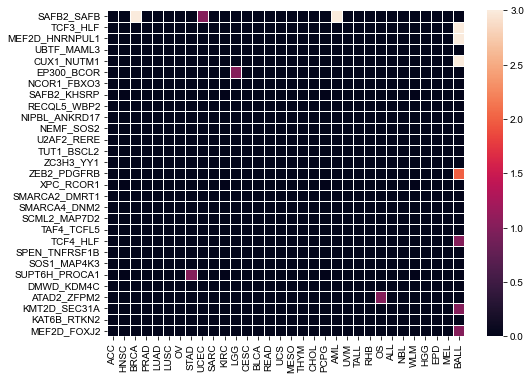

In [12]:
#print(fusiondf.columns.tolist())
#print(fusiondf[fusiondf['FO_Name'].isin(goodfoname)])

tmpdf=fusiondf[fusiondf['FO_Name'].isin(goodfoname)]
tmpcols=['FO_Name','ACC', 'HNSC', 'BRCA', 'PRAD', 'LUAD', 'LUSC', 'OV', 'STAD', 'UCEC', 'SARC', 'KIRC', 'LGG', 'CESC', 'BLCA', 'READ', 'UCS', 'MESO', 'THYM', 'CHOL', 'PCPG', 'AML', 'UVM', 'TALL', 'RHB', 'OS', 'ALL', 'NBL', 'WLM', 'HGG', 'EPD', 'MEL', 'BALL']
tmpcols2=['ACC', 'HNSC', 'BRCA', 'PRAD', 'LUAD', 'LUSC', 'OV', 'STAD', 'UCEC', 'SARC', 'KIRC', 'LGG', 'CESC', 'BLCA', 'READ', 'UCS', 'MESO', 'THYM', 'CHOL', 'PCPG', 'AML', 'UVM', 'TALL', 'RHB', 'OS', 'ALL', 'NBL', 'WLM', 'HGG', 'EPD', 'MEL', 'BALL']


#print(tmpdf[tmpcols])

plt.figure(figsize=(8,6))
sbn.heatmap(tmpdf[tmpcols2],linewidth=1,vmax=3)

plt.yticks(np.arange(0.5,len(goodfoname),1),goodfoname)